# Assignment 2

## Formalia:

Please read the [assignment overview page](https://github.com/suneman/socialdata2022/wiki/Assignment-1-and-2) carefully before proceeding. This page contains information about formatting (including formats etc.), group sizes, and many other aspects of handing in the assignment. 

_If you fail to follow these simple instructions, it will negatively impact your grade!_

**Due date and time**: The assignment is due on Monday, March the 28th, 2022 at 23:59. Hand in your files via [http://peergrade.io](http://peergrade.io/).

**Peergrading date and time**: _Remember that after handing in you have 1 week to evaluate a few assignments written by other members of the class_. Thus, the peer evaluations are due on Monday, April the 4th, 2022 at 23:59.

**Contributions**: In class I told you we will use DTU Learn. But Sune came up with a nicer idea!! **I'll send you a secret id by email later today** so you can add the contributions directly at the end of the notebook. They should look somewhat like this:

* id1: did this, this, and this
* id2: did that, that, and that
* id3: ...

**N.B.** It is NOT OK to say that each member contributed equally!

In [1]:
#IMPORT

import random

from bokeh.plotting import figure, show
from bokeh.models import ColumnDataSource
from bokeh.io import output_file, output_notebook
from bokeh.models import Legend
from bokeh.transform import dodge
from bokeh.models import ColumnDataSource, FactorRange
from bokeh.palettes import Category20b
from bokeh.transform import factor_cmap
from sklearn import preprocessing, tree, metrics

import pandas as pd
import numpy as np
from scipy import stats
import scipy, pylab
import seaborn as sns
import matplotlib.pyplot as plt
# from folium.plugins import HeatMap, HeatMapWithTime
import collections
import os
import datetime as dt
from scipy.stats import ttest_ind
from bokeh.plotting import figure, output_file, show
from bokeh.io import curdoc, show, output_notebook
from bokeh.models import ColumnDataSource, Grid, LinearAxis, Plot,  HoverTool
from bokeh.models.widgets import Panel, Tabs

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.svm import SVC
from sklearn.metrics import plot_confusion_matrix, confusion_matrix
from sklearn.model_selection import train_test_split

# !pip install jupyter_bokeh
output_notebook()

Loading BokehJS ...

This Assignment is based on the last three weeks of the course (Week 6-8). Before going on please load the data with the following line. In this way, you won't need to submit anything else than the .ipynb file and we will be able to run your notebook!

In [2]:
column_list = ["age", "sex", "race", "juv_fel_count", "juv_misd_count", "juv_other_count",
               "priors_count", "two_year_recid", "days_b_screening_arrest"]

df = pd.read_csv("https://raw.githubusercontent.com/suneman/socialdata2022/main/files/recidivism_dataset_sub.csv", usecols=column_list)

## Part 1: Predicting criminal recidivism

The following exercises are a subset of the ones we did during Week 6. If you have doubts or need more help, go back to the Week 6 notebook. There, you will find additional hints to complete the assignment.

> *Exercise 1:* Build a Decision Tree or a Random Forest. 

>   * Preprocess the data by only keeping records that have between $-30$ and $30$ days between the arrest and screening, then drop the `days_b_screening_arrest` column for the upcoming analysis.

<font color='blue'>
    
To ensure the dataset only includes the records where information about the days between the arrest and the screening is known, the data must be preprocessed. To do so, all records where this is not the case are removed from the dataset. 
    
</font>

In [3]:
# Remove rows that does not comply with condition
df = df[df.days_b_screening_arrest.between(-30, 30)]

# Remove column
df = df.drop(['days_b_screening_arrest'], axis=1)

>   * Some features we are working with are categorical, so we need to deal with them by using encoders. There are many different types, but we will focus on the `OneHotEncoder` and the `LabelEncoder`:
>      * Which encoder did you choose? Describe what it does and why you chose it.

<font color='blue'>
    
In order to be able to perform predictions based on the data provided, the data must be preprocessed as it includes two features that are categorical. These needs to be converted to numeric values using encoders. There are different types of encoders including One-Hot-Encoding and Label-Encoder. Both encoders are part of the SciKit-learn library.
    
The two categorical features in the data are "sex" and "race" as sex is categorized as either "male" or "female" and "race" as either "African-American", "Asian", "Caucasian", "Hispanic", "Native American", or "Other". 

The Label-Encoder converts each value in the columns to a number. Hereby, the text values are encoded by putting a running sequence for each text value. In this case, for the feature "sex", that would mean that 0 would be equal to "male" and 1 would be equal to "female", and the same goes for "race" where 0 would be equal to "African-American", 1 would be equal to "Asian", etc.

A disadvantage about Label-Encoder is that the numeric values can be misinterpreted by algorithms as having some sort of hierarchy or order in them even though this might not be the case. This issue can be avoided using One-Hot-Encoder as each value in a column is converted into a new column and assigned a 1 or 0 (true or false) value to the column. In this case, the encoding would create one column for "male" and one column for "female" as well as a column for each of the six possible values for "race", resulting in an addition of eight columns. The disadvantage of One-Hot-Encoder is that the encoding can cause a great number of columns. 
    
Both encoders can be used for this dataset. However, in this project, the Label-Encoder is used as the feature importances will be examined later on. For this, it makes more sense to look at the importance of gender and race overall.
    
</font>

In [4]:
from sklearn.preprocessing import LabelEncoder

# Create instance of labelencoder
labelencoder = LabelEncoder()

# Assign numerical values and store in a new column
df['sex_num'] = labelencoder.fit_transform(df['sex'])
df['race_num'] = labelencoder.fit_transform(df['race'])

>   * Split the data in Train/Test sets by using a 70/30 split and `random_state=42`.

<font color='blue'>
    
As it is the aim to create a model that predicts whether a person is going to recommit the crime within two years, the data has been split into a training set and a test set with a 70/30 split. This is done to be able to train and test the model. Moreover, to ensure the results can be reproduced when rerunning the code, the random state is set to 42.
    
</font>

In [5]:
# Create balanced training data
min_val = min((df.two_year_recid==0).value_counts())
df = df.loc[df['two_year_recid']==0][0:min_val].append(df.loc[df['two_year_recid']==1][0:min_val])

In [6]:
Y = df['two_year_recid']
X = df.drop(labels=['sex', 'race','two_year_recid'], axis = 1)

In [7]:
from sklearn.model_selection import train_test_split

# Split data into a training set and a test set
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state = 42)

>   * Fit a model to your Train set. Choose between a `DecisionTreeClassifier` or a `RandomForestClassifier`. 
>      * Describe how the model you chose works and why you chose it.

<font color='blue'>

The model that shall predict whether a person is going to recommit the crime within two years, can be made as an individual decision tree or as a random forest which includes multiple randomized decision trees.
    
Decision trees can determine the predictive value based on a series of questions and conditions for different features. Decision trees are simple, and thereby easy to build, use, and interpret. 
    
However, decision trees are prone to overfitting as it can perform really well on the training set but poorly on the test set. Random forests can help prevent overfitting as they averages the results of multiple randomized decision trees to find a better classification and thereby obtain a better predictive performance.

In this case, to create an optimized predictive model, a random forest is created.
    
</font>

In [8]:
from sklearn.ensemble import RandomForestClassifier

# Create model 
model = RandomForestClassifier(n_estimators = 10, random_state = 42)

# Fit model 
model.fit(X_train, Y_train)

# 
prediction_test = model.predict(X_test)

>   * Evaluate the performance of model on the test set, i.e compute Accuracy, Precision, and Recall. 
>      * What are your thoughts on these metrics? Is accuracy a good measure?

<font color='blue'>

The performance of the model can be evaluated based on its accuracy, precision, and recall score. A score of 0.5 is the baseline performance which is equal to a random guess. Therefore, the score should ideally be 1 for a perfect classifier.
        
Accuracy measures how much of the data was correctly classified that is the ratio of the number of true positives and true negatives over the the total number of predictions. To compute the accuracy, a confusion matrix is required. A confusion matrix is a summary of prediction results which can be classified as either true positive (TP), true negative (TN), false positive (FP), or false negative (FN).
    
**Accuracy = (TP + TN) / (TP + TN + FP + FN)**
    
It is important to note that accuracy is only a good measure, if the dataset is balanced meaning the number of positives and negatives are the same. Thereby, the use of the measure accuracy can result in misleading interpretation of results if the dataset is unbalanced.
    
Precision, on the other hand, also known as positive predictive value is a good measure of performance. It measures how often a prediction is true positive. Thereby, precision is the ratio of the number of true positives over the total number of positives that is the true positives and false positives. 
    
**Precision = TP / (TP + FP)**
    
As with precision, recall also known as sensitivity or true positive rate is also a good measure of performance. It indicates the percentage of positives that have been labeled correct. Thereby, recall is the number of true positives over the total number of positives which is the true positives and false negatives.
    
**Recall = TP / (TP + FN)**
    
As precision and recall are the best measures to evaluate the performance of a model, a metric that takes both scores into account also known as the F1-score is defined.
    
**F1 = 2 * (Precision * Recall) / (Precision + Recall)**

The F1-score should ideally be 1 which will be the case only when precision and recall are both 1. If the precision and recall score is high, the F1-score will be high. If the precision and recall is low, the F1-score will be low, and if the either the precision or recall is high and the other one low, the F1-score will be low.

*References:*

https://medium.com/analytics-vidhya/confusion-matrix-accuracy-precision-recall-f1-score-ade299cf63cd \
https://sentimllc.com/accuracy-precision-recall.html    
    
</font>

In [9]:
from sklearn import metrics

print("Original Model:")
print("")
print("Accuracy = ", metrics.accuracy_score(Y_test, prediction_test))
print("Precision = ", metrics.precision_score(Y_test, prediction_test))
print("Recall = ", metrics.recall_score(Y_test, prediction_test))

print("F1-score = ", metrics.f1_score(Y_test, prediction_test))

Original Model:

Accuracy =  0.6174377224199288
Precision =  0.6025974025974026
Recall =  0.5778331257783312
F1-score =  0.5899554990464082


<font color='blue'>
    
The precision, recall, and F1-score of the model is 0.60, 0.58, and 0.59, respectively.
    
The scores of the model is fairly more predictive than a random guess which has a score of just 0.5. However, the model is still far from perfectly predictive which entails a score of 1. 
    
As it can be seen, the precision of the model is highest, meaning that the model was most careful to avoid false positives. On the other hand, the recall of the model is lowest, meaning the model classified a greater number of false negatives as it was too careful. The F1-score indicates this imbalance.
    
The relatively low precision and recall score, and thereby F1-score, indicates that the data and model requires investigation and improvement. The uncertainty can be due to several things, among others a lot of variations in the dataset.
    
Classification reports including the precision, recall, and F1-score indicates what kind of errors the model makes whereas confusion matrices shows where the mistakes are made. By using both the classification report and the confusion matrix, it is possible to obtain a better understanding of how the model performs. 
        
</font>

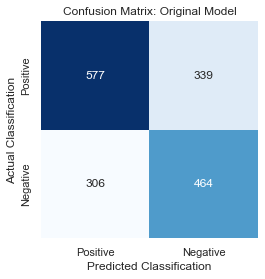

In [10]:
from sklearn.metrics import confusion_matrix
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt

# Create confusion matrix
mat = confusion_matrix(Y_test, prediction_test)
sns.heatmap(mat.T, square = True, annot = True, fmt = 'd', cbar = False, cmap = "Blues")

# Define layout for confusion matrix
plt.title("Confusion Matrix: Original Model")
plt.xlabel("Predicted Classification")
plt.ylabel("Actual Classification")
plt.xticks([0.5, 1.5], ["Positive", "Negative"])
plt.yticks([0.5, 1.5], ["Positive", "Negative"])

# Display confusion matrix
plt.show()

<font color='blue'>

From the confusion matrix above, it can be seen that the model predicts 577 true positives, 464 true negatives, 339 false negatives, and 306 false postives.
        
</font>

>   * Are your results tied to the specific hyperparameter set you used? Perform a `RandomizedSearchCV` and recompute the performance metric above with the hyperparameters found. What do you observe?

<font color='blue'>

To determine whether the results are tied to the specific hyperparameter set used, the model can be evaluated based on a wide range of values for each hyperparameter.

To do this, RandomizedSearchCV is used to define a grid of hyperparameter ranges, and randomly sample from the grid, performing K-Fold CV with each combination of values.
  
*References:*
    
https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74
    
</font>

In [11]:
# Number of trees in random forest
n_estimators = [200, 1000, 2000]

# Number of features to consider at every split
max_features = ['auto', 'sqrt']

# Maximum number of levels in tree
max_depth = [ 20, 80, 150]

# Minimum number of samples required to split a node
min_samples_split = [5,10,25,50]

# Minimum number of samples required at each leaf node
min_samples_leaf = [ 4,6,10,50]

# Method of selecting samples for training each tree
bootstrap = [True, False]

In [12]:
# Create param grid
param_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

print("The possible parameters when fitting the random search is as follows:")

param_grid

The possible parameters when fitting the random search is as follows:


{'n_estimators': [200, 1000, 2000],
 'max_features': ['auto', 'sqrt'],
 'max_depth': [20, 80, 150],
 'min_samples_split': [5, 10, 25, 50],
 'min_samples_leaf': [4, 6, 10, 50],
 'bootstrap': [True, False]}

In [13]:
# Create new model
rf_Model = RandomForestClassifier(random_state = 42)

In [14]:
from sklearn.model_selection import RandomizedSearchCV

# 
rf_RandomGrid = RandomizedSearchCV(estimator = rf_Model, param_distributions = param_grid, cv = 5, verbose=2, n_jobs = 4, random_state = 42)

In [15]:
# Fit new model
rf_RandomGrid.fit(X_train, Y_train)

print("")
print("The best parameters from fitting the random search is as follows:")

# Best parameters
rf_RandomGrid.best_params_

Fitting 5 folds for each of 10 candidates, totalling 50 fits

The best parameters from fitting the random search is as follows:


{'n_estimators': 1000,
 'min_samples_split': 50,
 'min_samples_leaf': 10,
 'max_features': 'sqrt',
 'max_depth': 20,
 'bootstrap': True}

In [16]:
from sklearn import metrics

#
prediction_test1 = rf_RandomGrid.predict(X_test)

print("Original Model:")
print("")
print("Accuracy = ", metrics.accuracy_score(Y_test, prediction_test))
print("Precision = ", metrics.precision_score(Y_test, prediction_test))
print("Recall = ", metrics.recall_score(Y_test, prediction_test))

print("F1-score = ", metrics.f1_score(Y_test, prediction_test))

print("")
print("Optimized Model:")
print("")

print("Accuracy = ", metrics.accuracy_score(Y_test, prediction_test1))
print("Precision = ", metrics.precision_score(Y_test, prediction_test1))
print("Recall = ", metrics.recall_score(Y_test, prediction_test1)) 
print("F1-score = ", metrics.f1_score(Y_test, prediction_test1))

Original Model:

Accuracy =  0.6174377224199288
Precision =  0.6025974025974026
Recall =  0.5778331257783312
F1-score =  0.5899554990464082

Optimized Model:

Accuracy =  0.6743772241992882
Precision =  0.6688829787234043
Recall =  0.6264009962640099
F1-score =  0.6469453376205787


<font color='blue'>

As it can be seen from the differentiating scores above, the results of the original model is tied to the specific hyperparameter set that was used.
    
With the randomized hyperparameters found, it can be seen that the model obtains a better predictive performance. Both the accuracy as well as the precision and recall, and thereby the F1-score, is higher for the optimized model than the original model.
    
It can be seen that the F1-score is increased by 0.05, equivalent to 5%. However, the precision score is still higher than the recall score which was the case for the original model as well.
    
</font>

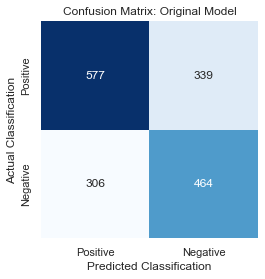

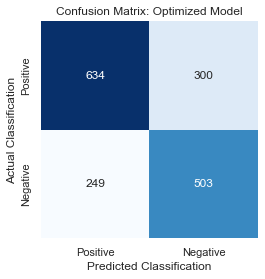

In [17]:
# Create confusion matrix
mat = confusion_matrix(Y_test, prediction_test)
sns.heatmap(mat.T, square = True, annot = True, fmt = 'd', cbar = False, cmap = "Blues")

# Define layout for confusion matrix
plt.title("Confusion Matrix: Original Model")
plt.xlabel("Predicted Classification")
plt.ylabel("Actual Classification")
plt.xticks([0.5, 1.5], ["Positive", "Negative"])
plt.yticks([0.5, 1.5], ["Positive", "Negative"])

# Display confusion matrix
plt.show()

# Create confusion matrix
mat = confusion_matrix(Y_test, prediction_test1)
sns.heatmap(mat.T, square = True, annot = True, fmt = 'd', cbar = False, cmap = "Blues")

# Define layout of confusion matrix
plt.title("Confusion Matrix: Optimized Model")
plt.xlabel("Predicted Classification")
plt.ylabel("Actual Classification")
plt.xticks([0.5, 1.5], ["Positive", "Negative"])
plt.yticks([0.5, 1.5], ["Positive", "Negative"])

# Display confusion matrix
plt.show()

<font color='blue'>

From the confusion matrices above, it can be seen that the optimized model has significantly more true positives and true negatives and thereby less false positives and false negatives, causing a better predictive performance.
    
</font>

>   * Visualize the tree. There are different options to do so. You can have a look at Week 6 for hints on how to do it. What do you observe?

Original random forest:
Decision tree number 1 out of 10


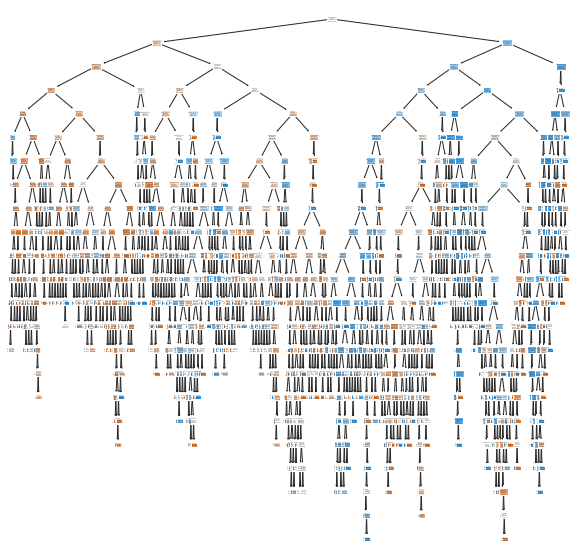

In [18]:
import matplotlib.pyplot as plt
from sklearn import tree

print("Original random forest:")
print("Decision tree number 1 out of", len(model.estimators_))

plt.figure(figsize = (10, 10))
tree.plot_tree(model.estimators_[0], feature_names = X.columns,  filled=True)

plt.show()

Optimized random forest:
Decision tree number 1 out of 1000


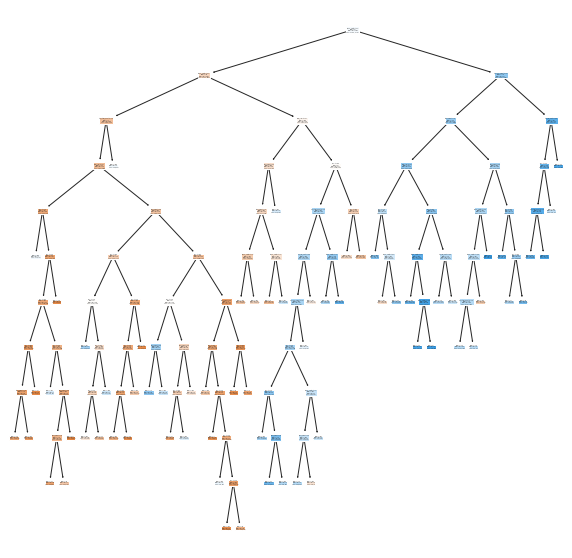

In [19]:
# Create model 
optmodel = RandomForestClassifier(n_estimators = 1000, min_samples_split = 50, min_samples_leaf = 10, max_features = "sqrt", max_depth = 20, bootstrap = True, random_state = 42)

# Fit model 
optmodel.fit(X_train, Y_train)

# 
prediction_test2 = optmodel.predict(X_test)

print("Optimized random forest:")
print("Decision tree number 1 out of", len(optmodel.estimators_))

plt.figure(figsize = (10, 10))
tree.plot_tree(optmodel.estimators_[0], feature_names = X.columns,  filled=True)

plt.show()

In [20]:
print("Total number of decision trees in original random forest:", len(model.estimators_))
print("Total number of decision trees in optimized random forest:", len(optmodel.estimators_))

Total number of decision trees in original random forest: 10
Total number of decision trees in optimized random forest: 1000


In [21]:
print("Maximum depth of decision trees in original random forest:")
print("")
print(" 1 out of 10:", model.estimators_[0].get_depth())
print(" 2 out of 10:", model.estimators_[1].get_depth())
print(" 3 out of 10:", model.estimators_[2].get_depth())
print(" 4 out of 10:", model.estimators_[3].get_depth())
print(" 5 out of 10:", model.estimators_[4].get_depth())
print(" 6 out of 10:", model.estimators_[5].get_depth())
print(" 7 out of 10:", model.estimators_[6].get_depth())
print(" 8 out of 10:", model.estimators_[7].get_depth())
print(" 9 out of 10:", model.estimators_[8].get_depth())
print("10 out of 10:", model.estimators_[9].get_depth())

Maximum depth of decision trees in original random forest:

 1 out of 10: 22
 2 out of 10: 24
 3 out of 10: 23
 4 out of 10: 23
 5 out of 10: 23
 6 out of 10: 23
 7 out of 10: 26
 8 out of 10: 27
 9 out of 10: 26
10 out of 10: 24


In [22]:
print("Maximum depth of decision trees in optimized random forest:")
print("")
print(" 1 out of 10:", optmodel.estimators_[0].get_depth())
print(" 2 out of 10:", optmodel.estimators_[1].get_depth())
print(" 3 out of 10:", optmodel.estimators_[2].get_depth())
print(" 4 out of 10:", optmodel.estimators_[3].get_depth())
print(" 5 out of 10:", optmodel.estimators_[4].get_depth())
print(" 6 out of 10:", optmodel.estimators_[5].get_depth())
print(" 7 out of 10:", optmodel.estimators_[6].get_depth())
print(" 8 out of 10:", optmodel.estimators_[7].get_depth())
print(" 9 out of 10:", optmodel.estimators_[8].get_depth())
print("10 out of 10:", optmodel.estimators_[9].get_depth())

Maximum depth of decision trees in optimized random forest:

 1 out of 10: 11
 2 out of 10: 15
 3 out of 10: 11
 4 out of 10: 15
 5 out of 10: 13
 6 out of 10: 11
 7 out of 10: 15
 8 out of 10: 12
 9 out of 10: 16
10 out of 10: 13


<font color='blue'>

The original random forest includes 10 randomized decision trees. Furthermore, the maximum depth of each of the decision tree is ranging from 22 to 27. The number of terminal nodes increases quickly with depth. Therefore, these decision trees are fairly large.

For a random forest, a large number of trees will result in a better performance. However, more trees also mean more computational cost and after a certain number of trees, the improvement is negligible.    
    
The optimized random forest includes 1000 randomized decision trees with a maximum depth ranging from 11-16 (based on the first 10 decision trees). Hereby, the number of terminal nodes are smaller making the decision trees easier to interpret.
    
</font>

Before going on. Assign the predictions on the test set of your best model to the `y_hat` variable, and their related probabilities to the `y_prob` variable. Remember to use: `y_prob = model.predict_proba(X_test)`

**N.B.** Set a specific `random_state` in your model too. Otherwise if we rerun your results we might not be able to reproduce them!

## Part 2: Fairness and bias in Machine Learning

We already know the model you've built is biased. In the next exercises we are going to apply a debiasing method. Please, refer to Week 7, Part 3 for more hints on how to solve these exercises. But first a couple of questions about bias.

>*Exercise 2.1:* A few questions about bias.
> * What are the most common types of data bias? 
> * What are the potential bias sources/types in our case-study (i.e. recidivism)?

> *Exercise 2.2:* Equal Odds. We are going to use `y_prob` to debias the ML model for African-Americans and Caucasians.
>
>    * Define the thresholds as `ths = np.linspace(1e-5,1-1e-5, 10)` and create a function that given a threshold `th` and `y_prob` returns `y_hat` as:
>
>$$\begin{cases}\hat{y}=1, \mbox{ if } y_{prob} > th \\ \hat{y}=0, \mbox{ otherwhise}\end{cases}    \mbox(1)$$ 
>
>
>   * To find the two thresholds that correct for the bias for African-Americans and Caucasians, you can either compute the distance of the ROC curve points or visually find the thresholds (as described in Week 7 Ex. 3.3).
>      * Describe the method you have used to find the thresholds (i.e. Visual or Computational) and how you used it to identify the thresholds. What thresholds did you find? 


<font color='blue'>

NB:The steps in Exercise 2.2 are carried out in Part 3.

The thresholds are found by visually inspecting the curves by plotting 10 different thresholds along each curve. The two closest point, within a reasonable range of the TPR and FPR-values (highest true/positve ratio), was found at approx. 0.48 for the Africans-Americans and 0.52 for the Caucacians. 
    </font>


>   * Debias the model output by re-computing $\hat{y}$ with the thresholds you found. 
>      * **Hint 1** This means that you have to take `y_prob` of your model African-Americans and apply Eq. (1) with the threshold for African-Americans, and then repeat with the different threshold for Caucasians.
>      * **Hint 2** You shouldn't rerun your model!
>   * Now plot the confusion matrices for African-Americans and Caucasian after you debiased the method. What do you observe? What do you think the problem with this debiasing method is (Refer to Week 7 for more hints)?

In [23]:
def roc_curve(y, y_probs, ths):
    roc = np.array([])
    ths_list= []
    tpr_list= []
    fpr_list= []  
    for j in range(len(ths)):
        y_hat = []
        for i in range(len(y_probs)):
            if y_probs[i][1] > ths[j]:
                y_hat.append(1)
            else:
                y_hat.append(0)
    return y_hat

## Part 3: Communicate your story and results to others

> *Exercise 3* Fill the article below with the title, subtitles, sections, visualizations and references!
> 
>    * **Note 1** Please, have a look at Week 8 for instructions on how to complete the article and make the visualizations.
>    * **Note 2** Make sure **you add the code** that generate your visualizations! This is really important.
>    * **Note 3** You should have all the necessary inputs to make the visualizations from the exercises in Part 1 and Part 2.

<font color='blue'>

**PLEASE NOTE!
There is no repetition of questions in the article below, why it has been written in black instead of blue for aesthetic purposes.**

</font>

# Can you be guilty of being innocent?

**Is machine learning really a reliable means of preventing crime?**

As modern technology advances at a rapid pace, we experience more public surveillance, new techniques, and tools for crime-fighting, making it become increasingly difficult to be a criminal in this day and age. But with new tools come new responsibilities! Judges and probation officers are taking advantage of a powerful tool in preventing crime. The tool in question is a commercial algorithm called COMPAS (*Correctional Offender Management Profiling for Alternative Sanctions*), which utilizes machine learning to give criminal defendants a score based on their likelihood of reoffending a crime. Now, a moral dilemma arises, should we really entrust machines with such important decisions that affect the future of fellow human beings, and can we even trust that the outcome is not being discriminatory or biased?

In the following article by ProPublica, we will have a look at COMPAS and the way it potentially discriminates, on the basis of just over 7000 data samples.


In [3]:
#First viz here: (Week 8 Visualization 1) Interactive visualization with Bokeh

df = pd.read_csv('https://raw.githubusercontent.com/suneman/socialdata2022/main/files/recidivism_dataset_sub.csv', 
                 usecols=['age','sex','race','is_recid','two_year_recid','c_charge_degree','days_b_screening_arrest'])

df = df[df.days_b_screening_arrest.between(-30, 30)]
df = df[(df['c_charge_degree']!='M')| (df['c_charge_degree']!='F')]
df = df.drop(['c_charge_degree','days_b_screening_arrest'],axis=1) 

In [18]:
#AGE----------

total = np.zeros(5)
recom = np.zeros(5)

for i in range(5):
    total[i] = df.loc[(df['age'] >= 0 + (i*20)) & (df['age'] <= 20 + (i*20))]['race'].count()  
    recom[i] = df.loc[(df['two_year_recid'] == 1) & (df['age'] >= 0 + (i*20)) & (df['age'] <= 20 + (i*20))]['race'].count()
    
df1=pd.DataFrame(data=total,columns=['Total'])
df1['NoRecommitted']=recom

In [19]:
age_interval = ['0-20 ','20-40','40-60','60-80','80-100']
df1['age_interval']=age_interval

data = {'age_interval' : age_interval,
        'NoRecommitted': df1['NoRecommitted'],
        'Total'   : df1['Total'],
        'frac1'   : df1['NoRecommitted']/df1['Total'],
        'frac2'   : df1['NoRecommitted']/df1['NoRecommitted'].sum()}

p1 = figure(x_range=age_interval, height=400, width = 900, title='Age and Recomitters',
           toolbar_location=None, tools="")

tab1 = Panel(child=p1, title="Age")

rec= p1.vbar(x='age_interval', width=0.5, bottom=0, top = 'Total', color='cornflowerblue', source=data
, legend_label = 'Total n. of samples', alpha=1)

tot=p1.vbar(x='age_interval', width=0.5, bottom=0, top = 'NoRecommitted', color='orange', source=data
, legend_label = 'N. recommitted crimes', alpha=1)

p1.legend.click_policy="hide" 

p1.add_layout(p1.legend[0], 'right')

hover = HoverTool(renderers=[tot])
hover.tooltips = [('Number of samples in age group','@Total'),('Number of recommitted crimes in age group','@NoRecommitted'),('Fraction of recomitted crimes in age category', '@frac1'),('Fraction of total recomitted crimes across age groups', '@frac2')]
p1.add_tools(hover)

p1.xaxis.axis_label = 'Age'
p1.yaxis.axis_label = 'No. of Samples'

# show(p1)

In [20]:
#SEX----------

fe_tot=df['age'].loc[(df['sex'] == 'Female')].count() 
fe_rec=df['age'].loc[(df['two_year_recid'] == 1) & (df['sex'] == 'Female')].count() 
ma_tot=df['age'].loc[(df['sex'] == 'Male')].count() 
ma_rec=df['age'].loc[(df['two_year_recid'] == 1) & (df['sex'] == 'Male')].count() 

df1=pd.DataFrame(data=[ma_tot,fe_tot],columns=['Total'])
df1['NoRecommitted']=[ma_rec, fe_rec]
df1['Sex']=['Male','Female']

In [21]:
Sex = ['Male','Female']
data = {'Sex' : Sex,
        'NoRecommitted': df1['NoRecommitted'],
        'Total'   : df1['Total'],
        'frac1'   : df1['NoRecommitted']/df1['Total'],
        'frac2'   : df1['NoRecommitted']/df1['NoRecommitted'].sum()}

p2 = figure(x_range=Sex, height=400, width = 900, title='Sex and Recomitters',
           toolbar_location=None, tools="")
tab2 = Panel(child=p2, title="Sex")

rec= p2.vbar(x='Sex', width=0.5, bottom=0, top = 'Total', color='cornflowerblue', source=data
, legend_label = 'Total n. of samples', alpha=1)

tot=p2.vbar(x='Sex', width=0.5, bottom=0, top = 'NoRecommitted', color='orange', source=data
, legend_label = 'N. recommitted crimes', alpha=1)

p2.legend.click_policy="hide" 

p2.add_layout(p2.legend[0], 'right')

hover = HoverTool(renderers=[tot])
hover.tooltips = [('Number of samples in sex group','@Total'),('Number of recommitted crimes in sex group','@NoRecommitted'),('Fraction of recomitted crimes in sex category', '@frac1'),('Fraction of total recomitted crimes across sex groups', '@frac2')]
p2.add_tools(hover)

p2.xaxis.axis_label = 'Sex'
p2.yaxis.axis_label = 'No. of Samples'

# show(p2)

In [16]:
#RACES----------

races=df['race'].unique()

total = np.zeros(len(races))
recom = np.zeros(len(races))

for i in range(len(races)):
    total[i] = df.loc[(df['race'] == races[i])]['race'].count()  
    recom[i] = df.loc[(df['two_year_recid'] == 1) & (df['race'] == races[i])]['race'].count()
    
df1=pd.DataFrame(data=total,columns=['Total'])
df1['NoRecommitted']=recom
df1['Race']=races

In [17]:
Race = races
data = {'Race' : Race,
        'NoRecommitted': df1['NoRecommitted'],
        'Total'   : df1['Total'],
        'frac1'   : df1['NoRecommitted']/df1['Total'],
        'frac2'   : df1['NoRecommitted']/df1['NoRecommitted'].sum()}

p3 = figure(x_range=Race, height=400, width = 900, title='Race and Recomitters',
           toolbar_location=None, tools="")

tab3 = Panel(child=p3, title="Race")

rec= p3.vbar(x='Race', width=0.5, bottom=0, top = 'Total', color='cornflowerblue', source=data
, legend_label = 'Total n. of samples', alpha=1)

tot=p3.vbar(x='Race', width=0.5, bottom=0, top = 'NoRecommitted', color='orange', source=data
, legend_label = 'N. recommitted crimes', alpha=1)

p3.legend.click_policy="hide" 

p3.add_layout(p3.legend[0], 'right')

hover = HoverTool(renderers=[tot])
hover.tooltips = [('Number of samples in race group','@Total'),('Number of recommitted crimes in race group','@NoRecommitted'),('Fraction of recomitted crimes in race category', '@frac1'),('Fraction of total recomitted crimes across race groups', '@frac2')]
p3.add_tools(hover)

p3.xaxis.axis_label = 'Races'
p3.yaxis.axis_label = 'No. of Samples'


# show(p3)

In [22]:
tabs = Tabs(tabs=[ tab1, tab2, tab3 ])

show(tabs)

**Can we trust the data, or is it biased?**

The interactive bar plot above shows the distribution of the roughly 7000 data samples in three categories. The three categories being *Age*, *Sex* and *Race* can be selected using the toggle in the top of the visualization. Each category shows the distribution of the total number of samples and number of recommitted crimes for different age, sex, and race groups. By hovering over the bar in each group, the number of samples within the group will be shown together with the number of recommitted crimes as well as the fraction of recommitted crimes to number of samples and the fraction of recommitted crimes within the group to that of across the groups.

It becomes clear pretty quickly that some groups within the three categories are largely contributing to the total number of samples. Taking a look at e.g. the age category, where the age group 20-40 contributes with more than half of the total samples, whereas the age group 0-20 only accounts for around 2.5% of the total samples. The same tendency is seen within the sex and race category where males and African-Americans have the highest contribution respectivily. This gives a skewed view of the reality as some groups are highly represented and some are heavily underrepresented. This underrepresentation of some groups can result in a distortion of the true picture of the population within the group.

By hovering over e.g. the race group African-American, 52.3% of the total samples within the group recommitted a crime, while in the Caucasian group 39.1% recommitted. However, it is also seen that recommitted crimes in the African-American group account for 59.1% of the total recommitted crimes across the groups, while that of the caucations account for 29.3%. This suggests that the probability of an African-American recommitting a crime is larger than the probability of a Caucasion. The sample size of the African-American group is however larger than that of the Caucasian, generating sampling bias, or more specific, undercoverage bias [1]. A great example of undercoverage bias is when the magazine Literary Digest in 1936 made an inadequate sample of the population, resulting in a wrongful prediction of the presidential election [2].

In [32]:
#Second viz here: (Week 8 Visualization 2) plot with 3 subplots (Feature importances, Confusion Matrix, Percentage difference)

df = pd.read_csv('https://raw.githubusercontent.com/suneman/socialdata2022/main/files/recidivism_dataset_sub.csv', 
                 usecols=['age','sex','race','juv_fel_count','juv_misd_count','juv_other_count','priors_count','is_recid','days_b_screening_arrest','c_charge_degree','two_year_recid'])

In [33]:
df = df[df.days_b_screening_arrest.between(-30, 30)]
df = df.drop(['is_recid','c_charge_degree', 'days_b_screening_arrest'], axis=1)

In [34]:
# creating instance of labelencoder
labelencoder = LabelEncoder()

# Assigning numerical values and storing in another column
df['sex_num'] = labelencoder.fit_transform(df['sex'])
df['race_num'] = labelencoder.fit_transform(df['race'])

#creating equal training data
min_val=min((df.two_year_recid==0).value_counts())
df=df.loc[df['two_year_recid']==0][0:min_val].append(df.loc[df['two_year_recid']==1][0:min_val])

In [35]:
Y = df['two_year_recid']
X = df.drop(labels=['sex','race','two_year_recid'], axis= 1)

In [36]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=10)

In [37]:
# Number of trees in random forest
n_estimators = [200, 1000, 2000]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [ 20, 80, 150]
# Minimum number of samples required to split a node
min_samples_split = [5,10,25,50]
# Minimum number of samples required at each leaf node
min_samples_leaf = [ 4,6, 10,50]
# Method of selecting samples for training each tree
bootstrap = [True, False]

In [38]:
# Create the param grid

param_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [39]:
rf_Model = RandomForestClassifier()
rf_RandomGrid = RandomizedSearchCV(estimator = rf_Model, param_distributions = param_grid, cv = 10, 
                                   verbose=2, n_jobs = 4, random_state=10)
rf_RandomGrid.fit(X_train, Y_train)
prediction_test = rf_RandomGrid.predict(X_test)

Fitting 10 folds for each of 10 candidates, totalling 100 fits


In [40]:
feature_list = ['Age', 'Juvenile felonies', 'Juvenile misdemeanors', 'Other juvenile convictions', 
                'Prior crimes', 'Sex','Race']

feature_imp = pd.Series(rf_RandomGrid.best_estimator_.feature_importances_, index = feature_list)

In [41]:
std = np.std([tree.feature_importances_ for tree in rf_RandomGrid.best_estimator_], axis=0)

clf = SVC(random_state=0)
clf.fit(X_train, Y_train)

SVC(random_state=0)

In [42]:
TN_tot, FP_tot, FN_tot, TP_tot = confusion_matrix(Y_test, prediction_test, normalize="true").ravel()

TN_afri, FP_afri, FN_afri, TP_afri = confusion_matrix(Y_test[X_test['race_num']==0],
                                                      prediction_test[X_test['race_num']==0], normalize="true").ravel()

TN_cauc, FP_cauc, FN_cauc, TP_cauc = confusion_matrix(Y_test[X_test['race_num']==2],
                                                      prediction_test[X_test['race_num']==2], normalize="true").ravel()

In [43]:
afri = [100*(FN_afri - FN_tot), 100*(TN_afri - TN_tot), 100*(FP_afri - FP_tot), 100*(TP_afri - TP_tot)]

cauc = [ 100*(FN_cauc - FN_tot), 100*(TN_cauc - TN_tot), 100*(FP_cauc - FP_tot), 100*(TP_cauc - TP_tot)]

index = ['FN', 'TN', 'FP','TP']

df = pd.DataFrame({'African': afri,'Caucian': cauc}, index=index)

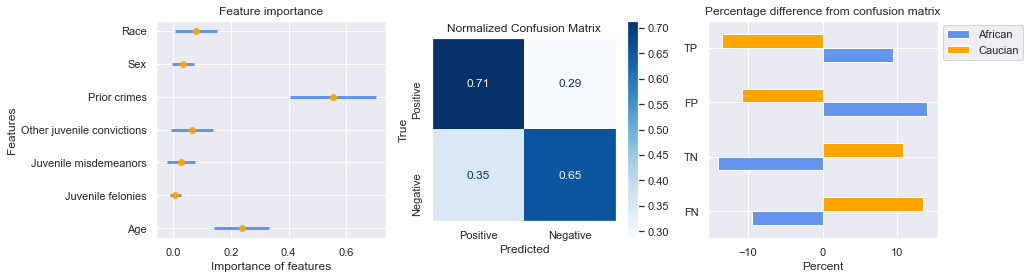

In [44]:
# fig = plt.figure()

## plot 1

# # Gets the axes object out after plotting
# ax = data.plot(...)

# # Turns off grid on the left Axis.
# ax.grid(False)

# # Turns off grid on the secondary (right) Axis.
# ax.right_ax.grid(False)

fig, axs = plt.subplots(1, 3, figsize=[14,4])

axs[0].plot(feature_imp, feature_list, "o", color='orange', alpha=0.9)
axs[0].set_title("Feature importance")
axs[0].set_xlabel('Importance of features')
axs[0].set_ylabel('Features')
axs[0].errorbar(feature_imp, feature_list, xerr=std, ecolor = 'cornflowerblue', elinewidth = 3, ls='none')
# axs[0].legend(['African-Americans', 'Caucacians'], loc='upper right')
# axs[0].grid(False)

## plot 2

# plot_confusion_matrix(clf, X_test, Y_test, normalize='true', display_labels=['Positive', 'Negative'], ax=axs[1],cmap='Blues') 
plot_confusion_matrix(clf, X_test, Y_test, normalize='true',ax=axs[1],cmap='Blues') 
#  display_labels=['Positive', 'Negative'],
axs[1].set_title("Normalized Confusion Matrix")
axs[1].set_xlabel('Predicted')
axs[1].set_ylabel('True')
axs[1].grid(False)
axs[1].set_yticklabels(['Positive', 'Negative'], rotation=90)
axs[1].set_xticklabels(['Positive', 'Negative'])

# matplotlib.pyplot.yticks(ticks=None, labels=None, rotation=None, ......)

## plot 3

df.plot.barh(ax=axs[2], color= ['cornflowerblue', 'orange'])

axs[2].set_title("Percentage difference from confusion matrix")
axs[2].set_xlabel('Percent')
axs[2].legend(['African-Americans', 'Caucacians'], loc='upper right')
# axs[2].grid(False)

# Shrink current axis by 20%
box = axs[2].get_position()
axs[2].set_position([box.x0, box.y0, box.width * 1, box.height])

# Put a legend to the right of the current axis
axs[2].legend(loc='center left', bbox_to_anchor=(1, 0.9))

plt.show()

**Bias in the COMPAS algorithm.**

As seen from the interactive bar plot, the data is biased, and as the predictive model is learning from this data, the model itself must also be biased. To check whether this is the case, the model is examined.

The three figures above shows the feature importance including the standard deviation, the normalized confusion matrix, and the percentage difference of the confusion matrices, respetively.

*Feature importance*

As it can be seen from the first figure, the importance of the different features differs. The figure shows that the number of prior crimes committed by the person is by far the most important feature for the predictions, hereafter comes the age of the person and third comes the race of the person. The least important feature is the number of previous juvenile felonies.

The feature importance provides both insight into the behavior of the model as well as better interpretability of the data. In case of a bias model, it is relevant to be able to see what features has the largest impact on the predictions to ensure this is taken into account.

*Confusion matrix*

The normalized confusion matrix of the model can be seen in the second figure. The figure shows that the model predicts that 0.71 out of 1.00 positives are true and 0.29 are false, and 0.65 out of 1.00 negatives are true and 0.35 are false.

The diagonal sum of the confusion matrix indicates the number of correct predictions (true positives and true negatives), and thus, the performance of the model. The higher the sum, the better the prediction. In this case, the maximum diagonal sum is 2 which is equivalent to a perfectly predictive model. However, the diagonal sum is 1.36, indicating some wrong predictions (false positives and false negatives). 

*Percentage difference from confusion matrix*

That the model is bias is clearly visible from the third and last figure. The figure shows the percentage difference of each of the two confusion matrices for the African-Americans and Caucasians, respectively, compared to the confusion matrix. If the model had not been bias, there would not be any difference. 

However, from the figure, it can be seen that the model predicts about 10-15% less or more of both true positives, false positives, true negatives, and false negatives. This is the case for both African-Americans and Caucasians. 
This shows that the model is bias just as the data is.

Furthermore, it can be seen, that the model predicts a greater percetage difference of false postives than true positives for African-Americans as well as it is a positive difference whereas it is the complete opposite case for Caucasians. This is evidence that the model is bias as it systematically skews the results of the the algorithm in favor of some races and against other races.

In [45]:
#Third viz here: (Week 8 Visualization 3) plot with 2 subplots (ROC curve and selected threshold, TPR and FPR before and after debiasing)

In [46]:
df = pd.read_csv('https://raw.githubusercontent.com/suneman/socialdata2022/main/files/recidivism_dataset_sub.csv', 
                 usecols=['age','sex','race','juv_fel_count','juv_misd_count','juv_other_count','priors_count','is_recid','days_b_screening_arrest','c_charge_degree','two_year_recid'])

In [47]:
df = df[df.days_b_screening_arrest.between(-30, 30)]
df = df.drop(['is_recid','c_charge_degree', 'days_b_screening_arrest'], axis=1)

In [48]:
# creating instance of labelencoder
labelencoder = LabelEncoder()

# Assigning numerical values and storing in another column
df['sex_num'] = labelencoder.fit_transform(df['sex'])
df['race_num'] = labelencoder.fit_transform(df['race'])

#creating equal training data
min_val=min((df.two_year_recid==0).value_counts())
df=df.loc[df['two_year_recid']==0][0:min_val].append(df.loc[df['two_year_recid']==1][0:min_val])

Y = df['two_year_recid']
X = df.drop(labels=['sex','race','two_year_recid'], axis= 1)

In [49]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=10)

In [50]:
# Number of trees in random forest
n_estimators = [200, 1000, 2000]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [ 20, 80, 150]
# Minimum number of samples required to split a node
min_samples_split = [5,10,25,50]
# Minimum number of samples required at each leaf node
min_samples_leaf = [ 4,6, 10,50]
# Method of selecting samples for training each tree
bootstrap = [True, False]

In [51]:
# Create the param grid
param_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [52]:
model=RandomForestClassifier(max_features='auto', n_estimators= 2000, min_samples_split = 50, min_samples_leaf = 50,
                             max_depth=20, bootstrap=True)
model.fit(X_train, Y_train)

pred = model.predict(X_test)

In [53]:
#This function takes as an input y, y_probs, thr 
#and returns the points to plot the ROC curve and their threshold

def roc_curve(y, y_probs, ths):
    roc = np.array([])
    ths_list= []
    tpr_list= []
    fpr_list= []  
    for j in range(len(ths)):
        y_hat = []
        for i in range(len(y_probs)):
            if y_probs[i][1] > ths[j]:
                y_hat.append(1)
            else:
                y_hat.append(0)
        tp = 0
        tn = 0
        fp = 0
        fn = 0
        for i in range(len(y)):
            if y_hat[i] == 1:
                if y_hat[i] == y[i]:
                    tp = tp + 1
                else:
                    fp = fp + 1

            if y_hat[i] == 0:
                if y_hat[i] == y[i]:
                    tn = tn + 1
                else:
                    fn = fn + 1
        TPR = tp / (tp + fn)
        FPR = fp / (fp + tn)
        roc = np.append(roc, [ths[j], FPR, TPR])
    return roc.reshape(-1, 3)

In [54]:
#This function takes as an input the points from one roc (first group) and the other (second group) and order the points by their distance in ascending order 
def closest_points(points1, points2):
    #initialize result
    res = list()
    #loop over points in group 1
    for pi in points1:
      #loop over points in group 2
      for pj in points2:
        #add points and their distance to res
        res.append(((pi,pj), np.linalg.norm(pi[1:] - pj[1:])))
    #return sorted result
    return sorted(res, key = lambda x: x[1])

In [55]:
y_probs_aa1 = model.predict_proba(X_test[X_test['race_num']==2])
y_aa1 = list(Y_test[X_test['race_num']==2])

y_probs_ca1 = model.predict_proba(X_test[X_test['race_num']==0])
y_ca1 = list(Y_test[X_test['race_num']==0])

ths = np.linspace(0.1,0.9, 10)

roc_aa1=roc_curve(y_aa1, y_probs_aa1, ths)
roc_ca1=roc_curve(y_ca1, y_probs_ca1, ths)

df_aa1= pd.DataFrame(data=roc_aa1)
df_ca1= pd.DataFrame(data=roc_ca1)

df_aa1=df_aa1.rename(columns={0: "Threshold", 1: "FPR", 2: "TPR"})
df_ca1=df_ca1.rename(columns={0: "Threshold", 1: "FPR", 2: "TPR"})

In [56]:
distance=pd.DataFrame(data=closest_points(roc_ca1, roc_aa1))

x_ca_bef = []
y_ca_bef = []
thresh_ca_bef=[]
dis_ca_bef=[]

x_aa_bef = []
y_aa_bef = []
thresh_aa_bef=[]
dis_aa_bef=[]

for i in range(len(distance)):
    
    if (distance[0][i])[0][2] > 0.25 and (distance[0][i])[0][2] < 0.75 and (distance[0][i])[0][1] < 0.75 and (distance[0][i])[0][1] > 0.25:
        x_ca_bef.append((distance[0][i])[0][1]) # x
        y_ca_bef.append((distance[0][i])[0][2]) # y
        thresh_ca_bef.append((distance[0][i])[0][0]) # thresh ca
        dis_ca_bef.append((distance[1][i]))       # distance
        
    if (distance[0][i])[1][2] > 0.2 and (distance[0][i])[1][2] < 0.75 and (distance[0][i])[1][1] < 0.75 and (distance[0][i])[1][1] > 0.25:
        x_aa_bef.append((distance[0][i])[1][1]) # x
        y_aa_bef.append((distance[0][i])[1][2]) # y
        thresh_aa_bef.append((distance[0][i])[1][0]) # thresh aa
        dis_aa_bef.append((distance[1][i]))       # distance

yy=((y_ca_bef[0]+y_aa_bef[0])/2)
xx=((x_ca_bef[0]+x_aa_bef[0])/2)

In [57]:
y_probs_aa2 = model.predict_proba(X_test[X_test['race_num']==2])
y_aa2 = list(Y_test[X_test['race_num']==2])

ths_aa = np.linspace(0.45,0.5, 10)
ths_ca = np.linspace(0.5,0.55, 10)

roc_aa_new=roc_curve(y_aa2, y_probs_aa2, ths_aa)

y_probs_ca2 = model.predict_proba(X_test[X_test['race_num']==0])
y_ca2 = list(Y_test[X_test['race_num']==0])

roc_ca_new=roc_curve(y_ca2, y_probs_ca2, ths_ca)

In [58]:
roc_aa1=roc_curve(y_aa1, y_probs_aa1, ths)
roc_ca1=roc_curve(y_ca1, y_probs_ca1, ths)

df_aa1= pd.DataFrame(data=roc_aa1)
df_ca1= pd.DataFrame(data=roc_ca1)

df_aa1=df_aa1.rename(columns={0: "Threshold", 1: "FPR", 2: "TPR"})
df_ca1=df_ca1.rename(columns={0: "Threshold", 1: "FPR", 2: "TPR"})

In [59]:
distance_new=pd.DataFrame(data=closest_points(roc_ca_new, roc_aa_new))

x_ca3 = []
y_ca3 = []
thresh_ca3=[]
dis_ca3=[]

x_aa3 = []
y_aa3 = []
thresh_aa3 = []
dis_aa3 = []

for i in range(len(distance_new)):
    if (distance_new[0][i])[0][2] > 0.2 and (distance_new[0][i])[0][2] < 0.8 and (distance_new[0][i])[0][1] < 0.8 and (distance_new[0][i])[0][1] > 0.2:
        x_ca3.append((distance_new[0][i])[0][1]) # x
        y_ca3.append((distance_new[0][i])[0][2]) # y
        thresh_ca3.append((distance_new[0][i])[0][0]) # thresh ca
        dis_ca3.append((distance_new[1][i]))       # distance
        
    if (distance_new[0][i])[1][2] > 0.2 and (distance_new[0][i])[1][2] < 0.8 and (distance_new[0][i])[1][1] < 0.8 and (distance_new[0][i])[1][1] > 0.2:
        x_aa3.append((distance_new[0][i])[1][1]) # x
        y_aa3.append((distance_new[0][i])[1][2]) # y
        thresh_aa3.append((distance_new[0][i])[1][0]) # thresh aa
        dis_aa3.append((distance_new[1][i]))       # distance
        
y1 = [y_ca_bef[0], y_ca3[0], x_ca_bef[0], x_ca3[0]]
y2 = [y_aa_bef[0], y_aa3[0], x_aa_bef[0], x_aa3[0]]

width = 0.40

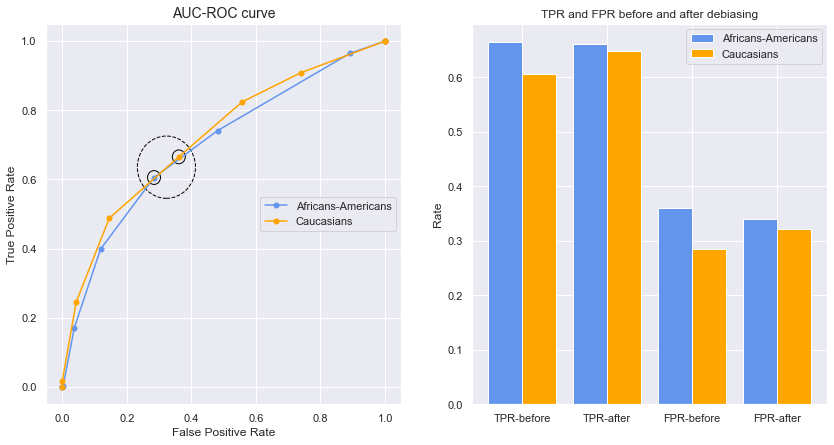

In [60]:
# fig = plt.figure()

## plot 1

fig, axs = plt.subplots(1, 2, figsize=[14,7])

####

circle1 = plt.Circle((xx, yy), 0.09, color='black',linestyle='dashed', fill=False)
circle_ca = plt.Circle((x_ca_bef[0], y_ca_bef[0]), 0.02, color='black', fill=False)
circle_aa = plt.Circle((x_aa_bef[0], y_aa_bef[0]), 0.02, color='black', fill=False)

axs[0].add_patch(circle1)
axs[0].add_patch(circle_ca)
axs[0].add_patch(circle_aa)

####
axs[0].plot(df_aa1['FPR'], df_aa1['TPR'], marker='.', markersize=10, label='Africans-Americans', color='cornflowerblue')
axs[0].plot(df_ca1['FPR'], df_ca1['TPR'], marker='.',markersize=10, label='Caucacians', color='orange')
axs[0].set_xlabel('False Positive Rate')
axs[0].set_ylabel('True Positive Rate')
axs[0].set_title("AUC-ROC curve",fontsize=14)
axs[0].legend(['Africans-Americans', 'Caucasians'], loc='center right')


## plot 2
x = np.arange(4)
labels=['TPR-before', 'TPR-after', 'FPR-before', 'FPR-after']
axs[1].bar(x-0.2, y1, width, color=['cornflowerblue'])
axs[1].bar(x+0.2, y2, width, color=['orange'])
axs[1].set_xticks(x)
axs[1].set_xticklabels([label for label in labels])
axs[1].set_ylabel('Rate')
axs[1].legend(['Africans-Americans', 'Caucasians'], loc='upper right')
axs[1].set_title("TPR and FPR before and after debiasing", fontsize=12)

plt.show()

**Creating a less biased COMPAS model**

It has now been established, that the data from the 7000 samples is biased to some extent, thereby making the COMPAS prediction algorithm biased and discriminatory. This calls for a debiasing of the algorithm, which can be done using several methods. The debiasing of this COMPAS model has been done by using the equalized odds method [3]. This method utilizes the true positive and false positive rates which can be plotted as a function of each other. This function is called a ROC (*Receiver Operating Characteristic*) curve and can be seen in the plot above to the left. The plot shows the relation between the true positive rate and the false positive rate for both African-Americans and Caucasians. The predictions of the model are influences by a threshold ranging between 0 and 1 moving along the ROC curve. This threshold is by default set to be 0.5, however this has a tendency of generalization [4]. The default threshold of 0.5 is shown with two circles along the ROC curve for both African-American and Caucasion, however optimal thresholds for both races can be found within the dotted circle. In the middle of the dotted circle, where the two curves intersect, an optimal threshold of 0.48 and 0.52 for African-Americans and Caucasians, respectively, can be read on the curve.

These new thresholds read from the ROC curve, should theoretically increase the true positive rate and decrease the false positive rate, making the model a better classifier and more debiased. It has prior been established that the algorithm is discriminative towards African-Americans because it predicts more false positives than for Caucasians. The bar plot above to the right shows the true positive rates and false positive rates for both of the races before and after the debiasing. The bias is pretty clear from the height of the 'before' bars, as the difference in the rates of the two races differs a lot. After the debiasing the true positive rates and the false positive rates of the two races have come closer to each other, meaning that the model is now much less discriminatory against African-American.

**Limitations and conclusions.** Write this part here. These are your main take aways, the end of your story, where you should also highlight possible implications/limitations of what you presented.




**References**

1. https://www.premise.com/blog/sampling-bias-what-you-need-to-know/
2. https://www.cambridge.org/core/journals/social-science-history/article/president-landon-and-the-1936-literary-digest-poll/E360C38884D77AA8D71555E7AB6B822C
3. Equalized odds postprocessing under imperfect group information (https://doi.org/10.48550/arxiv.1906.03284)
4. https://towardsdatascience.com/demystifying-roc-curves-df809474529a

**Assignment Contributions**:

* id1
* id2
* id3